In [ ]:
! pip install pymorphy2 transformers
! mkdir data
! wget -O data/IMDB_dataset.csv 'https://www.dropbox.com/s/0sltjrl1dl24npe/IMDB%20Dataset.csv?dl=0'

In [5]:
from collections import defaultdict
import re
import time

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score
from tqdm.auto import tqdm

import torch
from torch import nn
from torch.utils.data import (
    TensorDataset, DataLoader, RandomSampler, SequentialSampler
)

import nltk
import pymorphy2
from transformers import BertTokenizer, BertConfig
from transformers import AdamW, BertModel, BertForSequenceClassification

from keras.preprocessing.sequence import pad_sequences

import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import clear_output
%matplotlib inline

sns.set(font_scale=1.2)
sns.set_style(style='whitegrid')
device_num = 0

In [3]:
nltk.download('punkt')
nltk.download("stopwords")
device = f"cuda:{device_num}" if torch.cuda.is_available() else "cpu"

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
', '.join(nltk.corpus.stopwords.words('russian'))

'и, в, во, не, что, он, на, я, с, со, как, а, то, все, она, так, его, но, да, ты, к, у, же, вы, за, бы, по, только, ее, мне, было, вот, от, меня, еще, нет, о, из, ему, теперь, когда, даже, ну, вдруг, ли, если, уже, или, ни, быть, был, него, до, вас, нибудь, опять, уж, вам, ведь, там, потом, себя, ничего, ей, может, они, тут, где, есть, надо, ней, для, мы, тебя, их, чем, была, сам, чтоб, без, будто, чего, раз, тоже, себе, под, будет, ж, тогда, кто, этот, того, потому, этого, какой, совсем, ним, здесь, этом, один, почти, мой, тем, чтобы, нее, сейчас, были, куда, зачем, всех, никогда, можно, при, наконец, два, об, другой, хоть, после, над, больше, тот, через, эти, нас, про, всего, них, какая, много, разве, три, эту, моя, впрочем, хорошо, свою, этой, перед, иногда, лучше, чуть, том, нельзя, такой, им, более, всегда, конечно, всю, между'

## Предобработка текста

In [ ]:
announcement_text = """
Занятие 14. Обработка текстов (Natural Language Processing)

Добрый вечер, дорогие слушатели! 

Deep learning в 2021 году держится на двух китах: компьютерном зрении и обработке текстов. Именно в этих областях знания буквально за десятилетие был достигнут ошеломительный прогресс. 

На прошлом занятии мы увидели, как нейросетевые архитектуры естественным образом возникают в задачах обработки изображений и видео. На занятии 14 же мы проведём аналогичную экскурсию в мир обработки текстов. Мы обсудим такие темы как:

- Предобработка текстов. Токенизация, лемматизация, стемминг, паддинг. N-граммы.
- Эмбеддинги слов и предложений. BoW, CBoW, BoW + tf-idf, Word2Vec, Seq2Vec, GloVe.
- Языковые модели. Классификация текстов при помощи библиотеки huggingface.

Подключайтесь, будет интересно и полезно! Если вы будете иметь хотя бы базовые навыки в компьютерном зрении и обработке текстов, это сделает вас существенно более востребованным специалистом!

❗️Кроме того, в начале занятия будет большой тест по занятиям 9-12! Постарайтесь не опаздывать! ❗️

До встречи уже в эту субботу, 15 мая, в 18:30 по Москве по ссылке в Zoom (https://zoom.us/j/99997841028?pwd=VGE4MVRub2EvaWhSU0puWm1CWnBRQT09).
Идентификатор конференции:  999 9784 1028
Код доступа:  458573
"""

In [ ]:
class RuTextPreprocessor:
    def __call__(self, text):

        lowercase_text = text.lower()
        raw_tokens = nltk.word_tokenize(lowercase_text)
        clean_tokens = [
            re.sub('[^а-я]+', '', token) 
            for token in raw_tokens
        ]
        clean_tokens = [token for token in clean_tokens if token]

        morph_analyzer = pymorphy2.MorphAnalyzer(lang='ru')
        lemmatized_tokens = [
            morph_analyzer.parse(token) for token in clean_tokens
        ]
        lemmatized_tokens = [
            analysis_results[0].normal_form
            for analysis_results in lemmatized_tokens
            if analysis_results 
        ]

        stopwords = nltk.corpus.stopwords.words('russian')
        return [
            token for token in lemmatized_tokens if token not in stopwords
        ]

RuTextPreprocessor()(announcement_text)

['занятие',
 'обработка',
 'текст',
 'добрый',
 'вечер',
 'дорогой',
 'слушатель',
 'год',
 'держаться',
 'кит',
 'компьютерный',
 'зрение',
 'обработка',
 'текст',
 'именно',
 'область',
 'знание',
 'буквально',
 'десятилетие',
 'достигнуть',
 'ошеломительный',
 'прогресс',
 'прошлый',
 'занятие',
 'увидеть',
 'нейросетевой',
 'архитектура',
 'естественный',
 'образ',
 'возникать',
 'задача',
 'обработка',
 'изображение',
 'видео',
 'занятие',
 'проведм',
 'аналогичный',
 'экскурсия',
 'мир',
 'обработка',
 'текст',
 'обсудить',
 'тема',
 'предобработка',
 'текст',
 'токенизация',
 'лемматизация',
 'стемминг',
 'паддинга',
 'грамм',
 'эмбеддинг',
 'слово',
 'предложение',
 'языковой',
 'модель',
 'классификация',
 'текст',
 'помощь',
 'библиотека',
 'подключаться',
 'интересно',
 'полезно',
 'иметь',
 'хотя',
 'базовый',
 'навык',
 'компьютерный',
 'зрение',
 'обработка',
 'текст',
 'это',
 'сделать',
 'существенно',
 'востребовать',
 'специалист',
 'кроме',
 'начало',
 'занятие',
 'б

## BERT fine tunning

Основано на [BERT Fine-Tuning Sentence Classification notebook on Colab](https://colab.research.google.com/drive/1ywsvwO6thOVOrfagjjfuxEf6xVRxbUNO#scrollTo=6J-FYdx6nFE_).

[Transfer Learning](https://arxiv.org/abs/1808.01974) - это процесс дообучения на *новых данных* какой-либо нейросети, предобученной до этого на других данных.

Мы уже знакомились с этой техникой на примере картинок, попробуем теперь применить её к текстовым данным.

### Немного истории:

2018 год был поворотным длля NLP. Transfer learning, а именно такие модели как [ELMO](https://arxiv.org/abs/1802.05365) (Allen AI), [Open-GPT](https://s3-us-west-2.amazonaws.com/openai-assets/research-covers/language-unsupervised/language_understanding_paper.pdf) (Open AI), [BERT](https://arxiv.org/abs/1810.04805) (Google) позволили исследователям добиться "state of the art" результатов во многих задачах.

### BERT:

`BERT` (`Bidirectional Encoder Representations from Transformers`) - метод предварительной тренировки систем обработки евстественного языка, архитектурно - энкодер трансформера.

Как и модели из CV `BERT` можно использовать как:

* **Feature Extractor** (средство для извлечения признаков из текстовых данных)
* **Fine Tuning** (дообучить для конкретной задачи: classification, entity recognition, question answering и тд.)  
* **Использовать предобученную модель "из коробки"**  

Мы будем использовать библиотеку [`pytorch-transformers`](https://huggingface.co/transformers/index.html).

**Загрузка данных:**

Будем использовать датасет для бинарной классификации фильмов по их эмоциональной окраске [`IMDB Dataset of 50K Movie Reviews` ](https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews).

In [ ]:
df = pd.read_csv('data/IMDB_dataset.csv')

# 1 - позитивный отзыв, 0 - негативный
df.sentiment = df.sentiment.apply(lambda x: 1 if x=='positive' else 0)

In [ ]:
df.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


Приведем данные к необходимому формату.

Добавляем специальные токены `[CLS]` и `[SEP]` в начало и конец предложения соответственно. Они необходимы для корректной работы `BERT`.

`[SEP]` - токен, разделяющий предложения или определяющий конец предложения

`[CLS]` - токен, который ставится в начале предложения и используется для задачи классификации

*Пример:*

`[CLS] предложение A [SEP] предложение B [SEP]`



Скрытое состояние, относящееся к метке `[CLS]`, будет содержать в себе аггрегированное представление всего предложения, которое дальше будет использоваться для классификации.

In [ ]:
sentences = df.review.values
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.sentiment.values

С помощью токенизатора для BERT'а превратим наши текстовые данные в набор токенов из словаря предобученной модели.

`BertTokenizer` принимает на вход:

* `vocab_file` - словать. В нашем случае мы используем словарь предобученной модели  `bert-base-uncased`, так как в последствии будем её дообучать.

  `bert-base-uncased` - это "base" версия `BERTa`, где есть только буквы в нижнем регистре ("uncased"). В оригинальной статье рассказывается про две модели: "base" vs "large".

  [Здесь](https://huggingface.co/transformers/pretrained_models.html) можно ознакомиться со списком доступных предобученных моделей.

* `do_lower_case` - приводить ли вход к нижнему регистру

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenized_sentences = [tokenizer.tokenize(sent) for sent in tqdm(sentences)]

Пример токенизации:

In [ ]:
example_sent = "He remains characteristically confident and optimistic."
example_sent = "[CLS] " + example_sent + " [SEP]"
print("Предложение:", example_sent)
print("Токенизация:", tokenizer.tokenize(example_sent))

Предложение: [CLS] He remains characteristically confident and optimistic. [SEP]
Токенизация: ['[CLS]', 'he', 'remains', 'characteristic', '##ally', 'confident', 'and', 'optimistic', '.', '[SEP]']


Слово `characteristically` не встречается в словаре, однако существует способ разбить его на подслова, каждое из которых встречается в словаре. Подслова обозначаются специальными символами `##`. Если такого разбиения на подслова не существует, то слово целиком заменяется на токен `[UNK]`.

Преобразуем токены в их индексы в словаре BERT'а с помощью функции `tokenizer.convert_tokens_to_ids`.

In [ ]:
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tqdm(tokenized_sentences)]

Пример преобразования:

In [ ]:
print("Предложение:", example_sent)
tok = tokenizer.tokenize(example_sent)
print("Токенизация:", tok)
print("Индексы:    ", tokenizer.convert_tokens_to_ids(example_sent))

Предложение: [CLS] He remains characteristically confident and optimistic. [SEP]
Токенизация: ['[CLS]', 'he', 'remains', 'characteristic', '##ally', 'confident', 'and', 'optimistic', '.', '[SEP]']
Индексы:     100


BERT работает со входными данными одной длины. Построим гистограмму длин предложений.

In [ ]:
token_lens = [len(sent) for sent in tqdm(input_ids)]

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


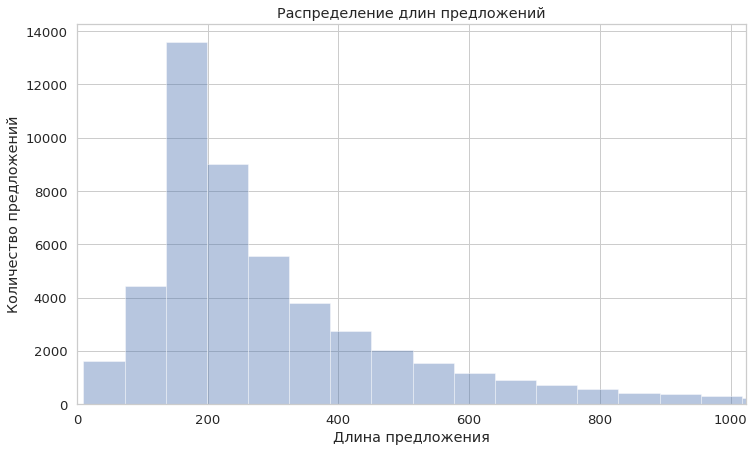

In [ ]:
plt.figure(figsize=(12,7))

sns.distplot(token_lens, kde=False)
plt.xlim([0, 1024])
plt.xlabel('Длина предложения')
plt.ylabel('Количество предложений')
plt.title('Распределение длин предложений')

plt.show()

Выбираем максимальную длину предложения. 

Предложения с большей длиной будем обрезать (`trancating`), с меньшей - дополнять токеном `[PAD]` до нужной длины (`padding`).

Можно выбрать обрезать (`trancating`) или дополнять (`padding`) предложение с конца (`truncating="post"`, `padding="post"`) или с начала (`truncating="pre"`, `padding="pre"`).

Токен `[PAD]` соответствует нулевому индексу в словаре `BERTa`.

In [ ]:
tokenizer.convert_tokens_to_ids("[PAD]")

0

Применяем `padding` и `truncation` ко входным данным.

In [ ]:
# выберем максимальную длину предложения
MAX_LEN = 256

padding = lambda texts: fpad_sequences(texts, 
                                      maxlen=MAX_LEN, 
                                      dtype="long", 
                                      truncating="post", 
                                      padding="post"
                                     )

# применяем padding и truncation ко входным данным
input_ids = padding(input_ids)

Пример применение `padding`. Предложением дополняется нулями до нужной длины:

In [ ]:
print("Предложение:", example_sent)
example_sent_ids = tokenizer.convert_tokens_to_ids(tokenizer.tokenize(example_sent))
print("После padding:", padding([example_sent_ids]))

Предложение: [CLS] He remains characteristically confident and optimistic. [SEP]
После padding: [[  101  2002  3464  8281  3973  9657  1998 21931  1012   102     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0   

Заполняем `attention mask`: последовательность нулей и единиц, где единицы обозначают токены предложения, нули - паддинг.

In [ ]:
get_attention_masks = lambda input_ids: [[float(i>0) for i in seq] for seq in input_ids]

attention_masks = get_attention_masks(input_ids)

In [ ]:
print("Пример:")
print("Предложение:", example_sent)
example_sent_ids = tokenizer.convert_tokens_to_ids(tokenizer.tokenize(example_sent))
print("После токенизации (индексы):", example_sent_ids)
example_sent_ids = padding([example_sent_ids])
print("После padding:", example_sent_ids)
print("Attention mask:", get_attention_masks(example_sent_ids))

Пример:
Предложение: [CLS] He remains characteristically confident and optimistic. [SEP]
После токенизации (индексы): [101, 2002, 3464, 8281, 3973, 9657, 1998, 21931, 1012, 102]
После padding: [[  101  2002  3464  8281  3973  9657  1998 21931  1012   102     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0

Делим на `train` и `test`.

In [ ]:
X_train, X_test, mask_train, mask_test, y_train, y_test = train_test_split(input_ids, 
                                                                           attention_masks, 
                                                                           labels, 
                                                                           test_size=0.3)

Делим на `train` и `val`.

In [ ]:
X_train, X_val, mask_train, mask_val, y_train, y_val = train_test_split(X_train,
                                                                        mask_train, 
                                                                        y_train, 
                                                                        test_size=0.1)

Преобразуем данные в `pytorch` тензоры:

In [ ]:
X_train = torch.tensor(X_train)
X_val = torch.tensor(X_val)
X_test = torch.tensor(X_test)

mask_train = torch.tensor(mask_train)
mask_val = torch.tensor(mask_val)
mask_test = torch.tensor(mask_test)

y_train = torch.tensor(y_train)
y_val = torch.tensor(y_val)
y_test = torch.tensor(y_test)

Выбираем размер батча и создаем итератор:

In [ ]:
batch_size = 16

train_data = TensorDataset(X_train, mask_train, y_train)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(X_val, mask_val, y_val)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)


test_data = TensorDataset(X_test, mask_test, y_test)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)


**Обучение модели:**

Данные подготовлены, пришло время обучения модели.

Мы хотим изменить предобученный `BERT` так, чтобы он выдавал метки для классификации текстов, а затем дообучить его на наших данных. Для этого вы можете взять готовую модификацию `BERTа` для классификации из библиотеки `transformers`: [`BertForSequenceClassification`](https://huggingface.co/transformers/_modules/transformers/modeling_bert.html#BertForSequenceClassification). Это обычный `BERT` с добавленным линейным слоем для классификации. Либо взять стандартную предобученную модель [`BertModel`](https://huggingface.co/transformers/model_doc/bert.html#bertmodel) и добавить слой для классификации (помним, что в nn.Sequential можно добавлять произвольные нейросети в качестве блоков).

В библиотеке [`transformers`](https://huggingface.co/transformers/model_doc/bert.html) есть аналогичные модели для разных NLP задач: `BertForNextSentencePrediction`, `BertForMaskedLM` и тд. Все они построены на основе одной и той же архитектуры и различаются только верхними слоями.

Мы будем использовать предобученную модель `bert-base-uncased`. `bert-base-uncased` - это "base" версия `BERTa`, где есть только буквы в нижнем регистре ("uncased"). В оригинальной статье рассказывается про две модели: "base" vs "large".

[Здесь](https://huggingface.co/transformers/pretrained_models.html) можно ознакомиться со списком доступных предобученных моделей.

При дообучении BERTа можно пользоваться всеми стандартными техниками: постепенной разморозкой слоёв, различными стратегиями работы с learning rate, чтобы сохранить "хорошие" веса в нижних слоях и ускорить обучение.

In [ ]:
custom_model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", num_labels=2
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight',

Удостоверимся, что архитектуры [`BertForSequenceClassification`](https://huggingface.co/transformers/_modules/transformers/modeling_bert.html#BertForSequenceClassification) и [`BertModel`](https://huggingface.co/transformers/model_doc/bert.html#bertmodel) с `fc`-слоем идентичны:

In [ ]:
custom_model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element


Если `num_labels == 1`, будет использован `nn.MSELoss`. (регрессия)

Если `num_labels > 1` - `nn.CrossEntropyLoss`. (классификация)

Дообучим `custom_model`

In [ ]:
custom_model = custom_model.to(device)

Будем обучать сразу все слои:

In [ ]:
optimizer = AdamW(custom_model.parameters(), lr=2e-5)

Пайплайн обучения:

In [ ]:
def plot_learning_curves(history):
    sns.set_style(style='whitegrid')
    fig = plt.figure(figsize=(20,7))

    plt.subplot(1,2,1)
    plt.title('Лосс', fontsize=15)
    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['loss']['val'], label='val')
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()

    plt.subplot(1,2,2)
    plt.title('Точность', fontsize=15)
    plt.plot(history['acc']['train'], label='train')
    plt.plot(history['acc']['val'], label='val')
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()
    plt.show()

In [ ]:
def train(
    model,
    optimizer, 
    train_batch_gen,
    val_batch_gen,
    num_epochs=50
):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.
    '''

    history = defaultdict(lambda: defaultdict(list))

    for epoch in tqdm(range(num_epochs), desc='epochs'):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0
        
        start_time = time.time()

        model.train(True) # устанавливаем поведение dropout / batch_norm  в обучение

        # На каждой "эпохе" делаем полный проход по данным
        for X_batch, mask_batch, y_batch in tqdm(
            train_batch_gen, desc='train sample batches'
        ):
            # Обучаемся на батче (одна "итерация" обучения нейросети)
            X_batch = X_batch.to(device)
            mask_batch = mask_batch.to(device)
            y_batch = y_batch.to(device)
            
            model_output = model(X_batch, mask_batch, labels=y_batch)
            loss = model_output.loss
            logits = model_output.logits
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            train_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            train_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # Подсчитываем лоссы и сохраням в "историю"
        train_loss /= len(train_batch_gen)
        train_acc /= len(train_batch_gen) 
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)
    
        model.train(False) # устанавливаем поведение dropout / batch_norm  в тестирование

        # Полный проход по валидации    
        for X_batch, mask_batch, y_batch in tqdm(
            val_batch_gen, desc='validation sample batches'
        ):
            X_batch = X_batch.to(device)
            mask_batch = mask_batch.to(device)
            y_batch = y_batch.to(device)
            
            # При использовании .no_grad() модель не будет считать и хранить градиенты.
            # Это ускорит процесс предсказания меток для тестовых данных.
            with torch.no_grad():
                model_output = model(X_batch, mask_batch, labels=y_batch)
                loss = model_output.loss
                logits = model_output.logits
            
            val_loss += np.sum(loss.detach().cpu().numpy())
            
            # применяем функцию max к каждому логиту из батча
            # функция max возвращает две величины: значения и индексы
            # выбираем индексы
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            val_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # Подсчитываем лоссы и сохраням в "историю"
        val_loss /= len(val_batch_gen)
        val_acc /= len(val_batch_gen) 
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)
        
        clear_output()

        # Печатаем результаты после каждой эпохи
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))
        
        if epoch > 0:
          plot_learning_curves(history)
        
    return model, history

Запустим на одну эпоху:

In [ ]:
custom_model, history = train(
    custom_model, optimizer, 
    train_dataloader, val_dataloader, 
    num_epochs=1
)

Обучается оно небыстро. :)

Оценим качество на тестовой выборке:

In [ ]:
custom_model.eval()
test_preds, test_labels = [], []

for X_batch, mask_batch, y_batch in tqdm(test_dataloader):
    X_batch = X_batch.to(device)
    mask_batch = mask_batch.to(device)
    
    # При использовании .no_grad() модель не будет считать и хранить градиенты.
    # Это ускорит процесс предсказания меток для тестовых данных.
    with torch.no_grad():
        logits = custom_model(X_batch, mask_batch).logits
        
    # применяем функцию max к каждому логиту из батча
    # функция max возвращает две величины: значения и индексы
    # выбираем индексы
    y_pred = logits.max(1)[1].detach().cpu().numpy()
    
    test_preds.extend(y_pred)
    test_labels.extend(y_batch.numpy())

In [ ]:
print('Accuracy: {0:.2f}%, Precision: {1:.2f}%, Recall: {2:.2f}%'.format(
    accuracy_score(test_labels, test_preds) * 100,
    precision_score(test_labels, test_preds) * 100,
    recall_score(test_labels, test_preds) * 100
))

Accuracy: 92.01%, Precision: 91.64%, Recall: 92.51%


Используя fine tuning предобученной модели получили достаточно хорошее качество предсказания.